In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from utils import *


In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


In [3]:
# Read Data
df = pd.read_csv('data/features_3_sec.csv')

In [4]:
# Identify Features and Target Label
y = df['label']
X = df.drop(columns = ['label','filename','length'])


In [5]:
# Scaling and Data Spiltting  
X = standardize(X)
X_dev, y_dev, X_test, y_test, X_train, y_train, X_val, y_val = split(X, y)


X_train shape: (8091, 57)
X_test shape: (999, 57)
X_val shape: (900, 57)


## Untuned model

In [6]:
# Model Training
model_ut = LogisticRegression()
model_ut.fit(X_dev, y_dev)

LogisticRegression()

In [7]:
# Model Testing
y_pred_ut = model_ut.predict(X_test)


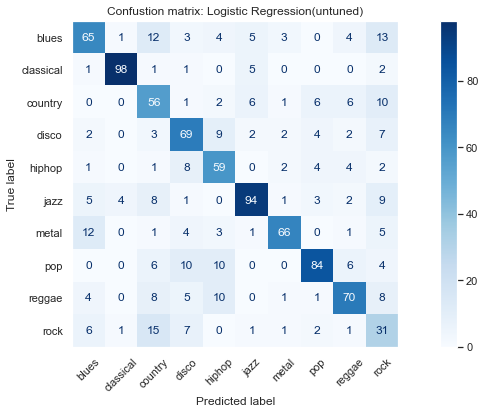

Accuracy : 0.69
Macro F-1 Score : 0.68


In [8]:
# Evaluate Model
class_labels_ut = list(model_ut.classes_)
macro_f1, accuracy = evaluate_model(y_pred_ut, y_test, class_labels_ut, 'Confustion matrix: Logistic Regression(untuned)')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

## Tuned model

In [9]:
# setting the validation index as per PredefinedSplit requirement, 0 for validation, -1 for training 

X_train['test_fold']= -1
X_val['test_fold']= 0

X_train_val_combined = pd.concat([X_train, X_val])
y_train_val_combined = pd.concat([y_train, y_val])

In [10]:
# Setting Hypertunning Using Grid Search

params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }
ps = PredefinedSplit(list(X_train_val_combined['test_fold']))
X_train_val_combined = X_train_val_combined.drop('test_fold', axis = 1)
X_train = X_train.drop('test_fold', axis = 1)
X_val = X_val.drop('test_fold', axis = 1)

grid_t = GridSearchCV(LogisticRegression(), params, cv = ps, verbose = 10)

# Model Training
grid_t.fit(X_train_val_combined, y_train_val_combined)

# https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 1/6] START C=0.001.....................................................
[CV 1/1; 1/6] END ......................C=0.001;, score=0.329 total time=   0.3s
[CV 1/1; 2/6] START C=0.01......................................................
[CV 1/1; 2/6] END .......................C=0.01;, score=0.440 total time=   1.8s
[CV 1/1; 3/6] START C=0.1.......................................................
[CV 1/1; 3/6] END ........................C=0.1;, score=0.602 total time=   2.7s
[CV 1/1; 4/6] START C=1.........................................................
[CV 1/1; 4/6] END ..........................C=1;, score=0.684 total time=   1.4s
[CV 1/1; 5/6] START C=10........................................................
[CV 1/1; 5/6] END .........................C=10;, score=0.697 total time=   0.5s
[CV 1/1; 6/6] START C=100.......................................................
[CV 1/1; 6/6] END ........................C=100;, 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]}, verbose=10)

In [11]:
print('Best Parameter C = %f with validation score: %.2f'%(grid_t.best_params_['C'], grid_t.best_score_ ))
best_model = grid_t.best_estimator_

Best Parameter C = 10.000000 with validation score: 0.70


In [12]:
# Another Way?
"""
params = [0.001, 0.01, 0.1, 1, 10, 100]
performance = []
models = []
for p in params:
    clf = LogisticRegression(C = p)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    results = classification_report(y_val, y_pred, output_dict = True)
    performance.append(results['accuracy'])
    models.append(clf)
best_parm =  params[np.argmax(performance)]
best_score = np.max(performance)
best_model = models[np.argmax(performance)]

print('Best Parameter C = %f with validation score: %.2f'%(best_parm,best_score ))
"""

"\nparams = [0.001, 0.01, 0.1, 1, 10, 100]\nperformance = []\nmodels = []\nfor p in params:\n    clf = LogisticRegression(C = p)\n    clf.fit(X_train, y_train)\n    y_pred = clf.predict(X_val)\n    results = classification_report(y_val, y_pred, output_dict = True)\n    performance.append(results['accuracy'])\n    models.append(clf)\nbest_parm =  params[np.argmax(performance)]\nbest_score = np.max(performance)\nbest_model = models[np.argmax(performance)]\n\nprint('Best Parameter C = %f with validation score: %.2f'%(best_parm,best_score ))\n"

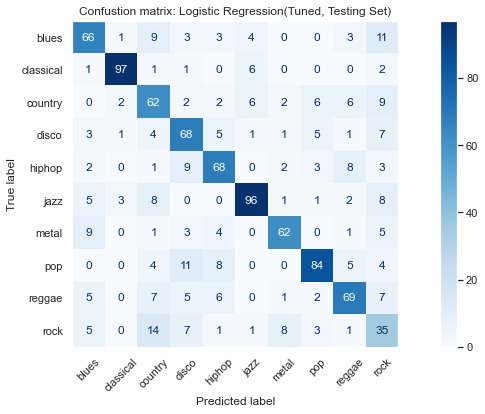

Test Set Accuracy : 0.71
Test Set Macro F-1 Score : 0.70


In [13]:
# Evaluate Model using test set
y_pred_test = best_model.predict(X_test)
class_labels = list(best_model.classes_)


macro_f1_test, accuracy_test = evaluate_model(y_pred_test, y_test, class_labels, 'Confustion matrix: Logistic Regression(Tuned, Testing Set)')
print('Test Set Accuracy : %.2f'%accuracy_test)
print('Test Set Macro F-1 Score : %.2f'%macro_f1_test)
